In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from cmocean import cm as cmo
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import numpy as np
import pandas as pd
import xarray as xr
import scipy
import glob
import matplotlib.dates as mdates
import datetime
import dask.array as da

In [2]:
Gdata = "http://tds.marine.rutgers.edu/thredds/dodsC/cool/glider/mab/Gridded/20070626T0000_20070714T0000_eline_ru06.nc"

In [3]:
df = xr.open_dataset(Gdata)

In [5]:
df

<xarray.Dataset>
Dimensions:                    (depth: 60, profile: 2020)
Coordinates:
  * depth                      (depth) float64 -1.0 -3.0 -5.0 ... -117.0 -119.0
Dimensions without coordinates: profile
Data variables:
    lat                        (profile) float64 39.65 39.65 ... 39.36 39.36
    lon                        (profile) float64 -72.42 -72.42 ... -74.02 -74.02
    time                       (profile) datetime64[ns] 2007-06-26T22:49:37.8...
    salinity                   (profile, depth) float64 ...
    temperature                (profile, depth) float64 ...
    salinity_raw               (profile, depth) float64 ...
    temperature_raw            (profile, depth) float64 ...
    brunt_vaisala_squared      (profile, depth) float64 ...
    brunt_vaisala_squared_raw  (profile, depth) float64 ...
    data_quality_flag          (profile, depth) float64 ...
    bb470                      (profile, depth) float64 ...
    bb532                      (profile, depth) float64 ...
    bb660                      (profile, depth) float64 ...
    chla                       (profile, depth) float64 ...
    cdom                       (profile, depth) float64 ...
Attributes:
    Title:                           RU glider data on standard depths
    Conventions:                     CF-1.0
    Institution:                     Institute for Marine and Coastal Science...
    source:                          /home/coolgroup/gliderData/archive/
    castfile:                        /home/coolgroup/gliderData/archive/07062...
    casttype:                        DOWN
    project:                         eline
    glider:                          ru06
    ascii_file:                      ru06_2007_177_0_0_sbd
    history:                         Created by /home/hunter/work/matlab/glid...
    DODS_EXTRA.Unlimited_Dimension:  profile

In [6]:
df['mdate'] = mdates.date2num(df.time)

In [7]:
print(df.mdate.shape, df.depth.shape)

D, MDATE = np.meshgrid(df.depth.values,df.mdate.values)

(2020,) (60,)


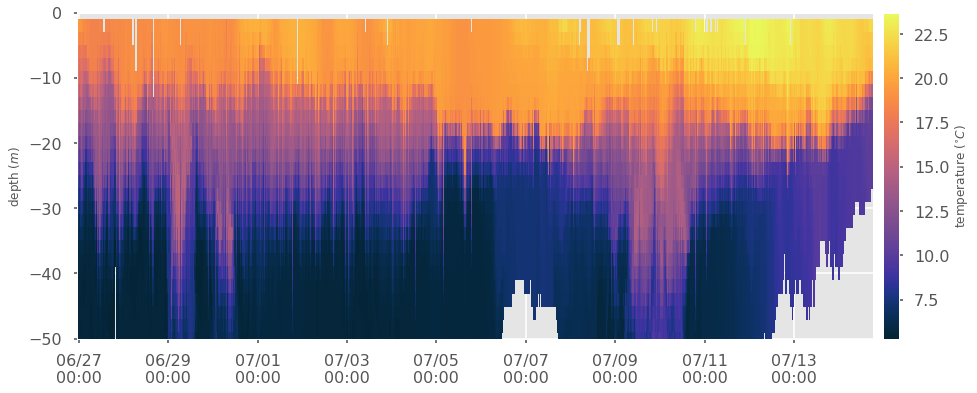

In [8]:
plt.figure(figsize=(17,6))
plt.pcolor(MDATE, D, df.temperature, cmap=cmo.thermal)
plt.colorbar(label='temperature ($^{\circ}C$)',pad=0.01)
plt.ylim([-50,0])
plt.ylabel('depth ($m$)')
myFmt = mdates.DateFormatter('%m/%d\n%H:%M')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.grid()
plt.show()